In [273]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [274]:
# Carga el dataset en un dataframe
df = pd.read_csv('weatherAUS.csv')

# Revisa si hay filas duplicadas
df.duplicated().sum() # 0 filas duplicadas

pd.set_option('display.max_columns', None)
df.describe(include='all')

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
count,145460,145460,143975.000000,144199.000000,142199.000000,82670.000000,75625.000000,135134,135197.000000,134894,141232,143693.000000,142398.000000,142806.000000,140953.000000,130395.00000,130432.000000,89572.000000,86102.000000,143693.000000,141851.00000,142199,142193
unique,3436,49,NaN,NaN,NaN,NaN,NaN,16,NaN,16,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2
top,2017-06-24,Canberra,NaN,NaN,NaN,NaN,NaN,W,NaN,N,SE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,No
freq,49,3436,NaN,NaN,NaN,NaN,NaN,9915,NaN,11758,10838,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,110319,110316
mean,NaN,NaN,12.194034,23.221348,2.360918,5.468232,7.611178,NaN,40.035230,NaN,NaN,14.043426,18.662657,68.880831,51.539116,1017.64994,1015.255889,4.447461,4.509930,16.990631,21.68339,NaN,NaN
std,NaN,NaN,6.398495,7.119049,8.478060,4.193704,3.785483,NaN,13.607062,NaN,NaN,8.915375,8.809800,19.029164,20.795902,7.10653,7.037414,2.887159,2.720357,6.488753,6.93665,NaN,NaN
min,NaN,NaN,-8.500000,-4.800000,0.000000,0.000000,0.000000,NaN,6.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,980.50000,977.100000,0.000000,0.000000,-7.200000,-5.40000,NaN,NaN
25%,NaN,NaN,7.600000,17.900000,0.000000,2.600000,4.800000,NaN,31.000000,NaN,NaN,7.000000,13.000000,57.000000,37.000000,1012.90000,1010.400000,1.000000,2.000000,12.300000,16.60000,NaN,NaN
50%,NaN,NaN,12.000000,22.600000,0.000000,4.800000,8.400000,NaN,39.000000,NaN,NaN,13.000000,19.000000,70.000000,52.000000,1017.60000,1015.200000,5.000000,5.000000,16.700000,21.10000,NaN,NaN
75%,NaN,NaN,16.900000,28.200000,0.800000,7.400000,10.600000,NaN,48.000000,NaN,NaN,19.000000,24.000000,83.000000,66.000000,1022.40000,1020.000000,7.000000,7.000000,21.600000,26.40000,NaN,NaN


# Limpieza y preprocesamiento

In [275]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [276]:
# Drop de filas con NaN en la feature objetivo
df = df.dropna(subset=['RainTomorrow'])

In [277]:
df['RainToday'] = df['RainToday'].map({'Yes': 1, 'No': 0}).astype('Int8')
df['RainTomorrow'] = df['RainTomorrow'].map({'Yes': 1, 'No': 0}).astype('Int8')

In [278]:
df['Cloud3pm'].value_counts(dropna=False)

Cloud3pm
NaN    57094
7.0    18052
1.0    14827
8.0    12407
6.0     8869
2.0     7153
3.0     6836
5.0     6743
4.0     5254
0.0     4957
9.0        1
Name: count, dtype: int64

In [279]:
df['Cloud9am'].value_counts(dropna=False)

Cloud9am
NaN    53657
7.0    19749
1.0    15558
8.0    14389
0.0     8587
6.0     8072
2.0     6442
3.0     5854
5.0     5510
4.0     4373
9.0        2
Name: count, dtype: int64

Por el rango de valores que asumen las variables **Cloud9am** y **Cloud3pm** asumimos que dichas variables están medidas en octas, que es la unidad de medida empleada para describir la nubosidad observable en un determinado lugar. https://es.wikipedia.org/wiki/Octa

In [280]:
def generar_csv_coordenadas(df):
    import time
    import pandas as pd
    from geopy.geocoders import Nominatim

    ubicaciones = df['Location'].unique()
    australia_coords = pd.DataFrame({"location": ubicaciones})

    geolocator = Nominatim(user_agent="australia_mapper")

    lats, lons = [], []

    def normalizar_nombre_ubicacion(ubicacion):
        for i in range(1, len(ubicacion)):
            if ubicacion[i].isupper():
                return ubicacion[:i] + " " + ubicacion[i:]
        return ubicacion

    nombres_ubicaciones =  map(normalizar_nombre_ubicacion, ubicaciones)

    for ubicacion in nombres_ubicaciones:
        result = geolocator.geocode(f"{ubicacion}, Australia", timeout=10)
        if result:
            lats.append(result.latitude)
            lons.append(result.longitude)
        else:
            print('No se encontró', ubicacion)
            lats.append(None)
            lons.append(None)
        time.sleep(1.1)  # máx 1 req/s


    australia_coords["lat"] = lats
    australia_coords["lon"] = lons

    australia_coords.to_csv("australian_locations.csv", index=False)

In [281]:
# generar_csv_coordenadas(df) # Descomentar para generar el CSV

In [282]:
# Df con coordenadas
australia_coords = pd.read_csv("australian_locations.csv")

# Genera variable frecuencia para cada ubicación
australia_coords['frecuencia'] = df['Location'].value_counts().values

In [283]:
import plotly.express as px

fig = px.scatter_geo(
    australia_coords,
    lat='lat',
    lon='lon',
    scope='oceania',
    color='frecuencia',
    hover_name='location',
    projection='natural earth',
    color_continuous_scale='Purp',
)

# Ajusta los límites del mapa para centrarse en Australia
fig.update_geos(
    lonaxis=dict(range=[min(australia_coords['lon'])-5, max(australia_coords['lon'])+5]),
    lataxis=dict(range=[min(australia_coords['lat'])-5, max(australia_coords['lat'])+5]),
)
fig.update_layout(width=1600,height=900)

fig.update_traces(marker_size=20)

fig.show()

Observamos que tenemos datos de muchas ubicaciones distintas, implicando que tendremos que generar una gran cantidad de variables dummys lo que corre riesgo de overfitting. Vamos a reducir la dimensionalidad agrupando ubicaciones según su sus tipos de clima, siguiendo la clasificación de Koppen. 

In [284]:
# Genera una nueva variable Climate basada en la clásificación de Koppen, utilizando la variable Location

location_koppen = {
    'Adelaide': 'Temperate',
    'Albany': 'Temperate',
    'Albury': 'Temperate',
    'AliceSprings': 'Arid',
    'BadgerysCreek': 'Temperate',
    'Ballarat': 'Temperate',
    'Bendigo': 'Temperate',
    'Brisbane': 'Temperate',
    'Cairns': 'Tropical',
    'Canberra': 'Temperate',
    'Cobar': 'Arid',
    'CoffsHarbour': 'Temperate',
    'Dartmoor': 'Temperate',
    'Darwin': 'Tropical',
    'GoldCoast': 'Temperate',
    'Hobart': 'Temperate',
    'Katherine': 'Tropical',
    'Launceston': 'Temperate',
    'Melbourne': 'Temperate',
    'Mildura': 'Arid',
    'Moree': 'Temperate',
    'MountGambier': 'Temperate',
    'MountGinini': 'Temperate',
    'Newcastle': 'Temperate',
    'Nhil': 'Temperate',
    'NorahHead': 'Temperate',
    'NorfolkIsland': 'Temperate',
    'Nuriootpa': 'Temperate',
    'PearceRAAF': 'Temperate',
    'Penrith': 'Temperate',
    'Perth': 'Temperate',
    'PerthAirport': 'Temperate',
    'Portland': 'Temperate',
    'Richmond': 'Temperate',
    'Sale': 'Temperate',
    'SalmonGums': 'Arid',
    'Sydney': 'Temperate',
    'SydneyAirport': 'Temperate',
    'Townsville': 'Tropical',
    'Tuggeranong': 'Temperate',
    'Uluru': 'Arid',
    'WaggaWagga': 'Temperate',
    'Walpole': 'Temperate',
    'Watsonia': 'Temperate',
    'Williamtown': 'Temperate',
    'Witchcliffe': 'Temperate',
    'Wollongong': 'Temperate',
    'Woomera': 'Arid',
}

In [285]:
# Genera la nueva variable en el df original y en el df de coordenadas
df['Climate'] = df['Location'].map(location_koppen)

australia_coords['Climate'] = australia_coords['location'].map(location_koppen)

In [286]:
import plotly.express as px

fig = px.scatter_geo(
    australia_coords,
    lat='lat',
    lon='lon',
    scope='oceania',
    color='Climate',
    hover_name='location',
    projection='natural earth',
    size='frecuencia',
)

# Ajusta los límites del mapa para centrarse en Australia
fig.update_geos(
    lonaxis=dict(range=[min(australia_coords['lon'])-5, max(australia_coords['lon'])+5]),
    lataxis=dict(range=[min(australia_coords['lat'])-5, max(australia_coords['lat'])+5]),
)
fig.update_layout(width=1600,height=900)

fig.show()

### Split Train/Test

In [287]:
# Separa el 80% para train y 20% para test
train, test= train_test_split(df, test_size=0.2, random_state=1)

# EDA

In [288]:
variables_numericas = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
print(f"Hay {len(variables_numericas)} variables_numericas:\n{variables_numericas}")

Hay 16 variables_numericas:
['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']


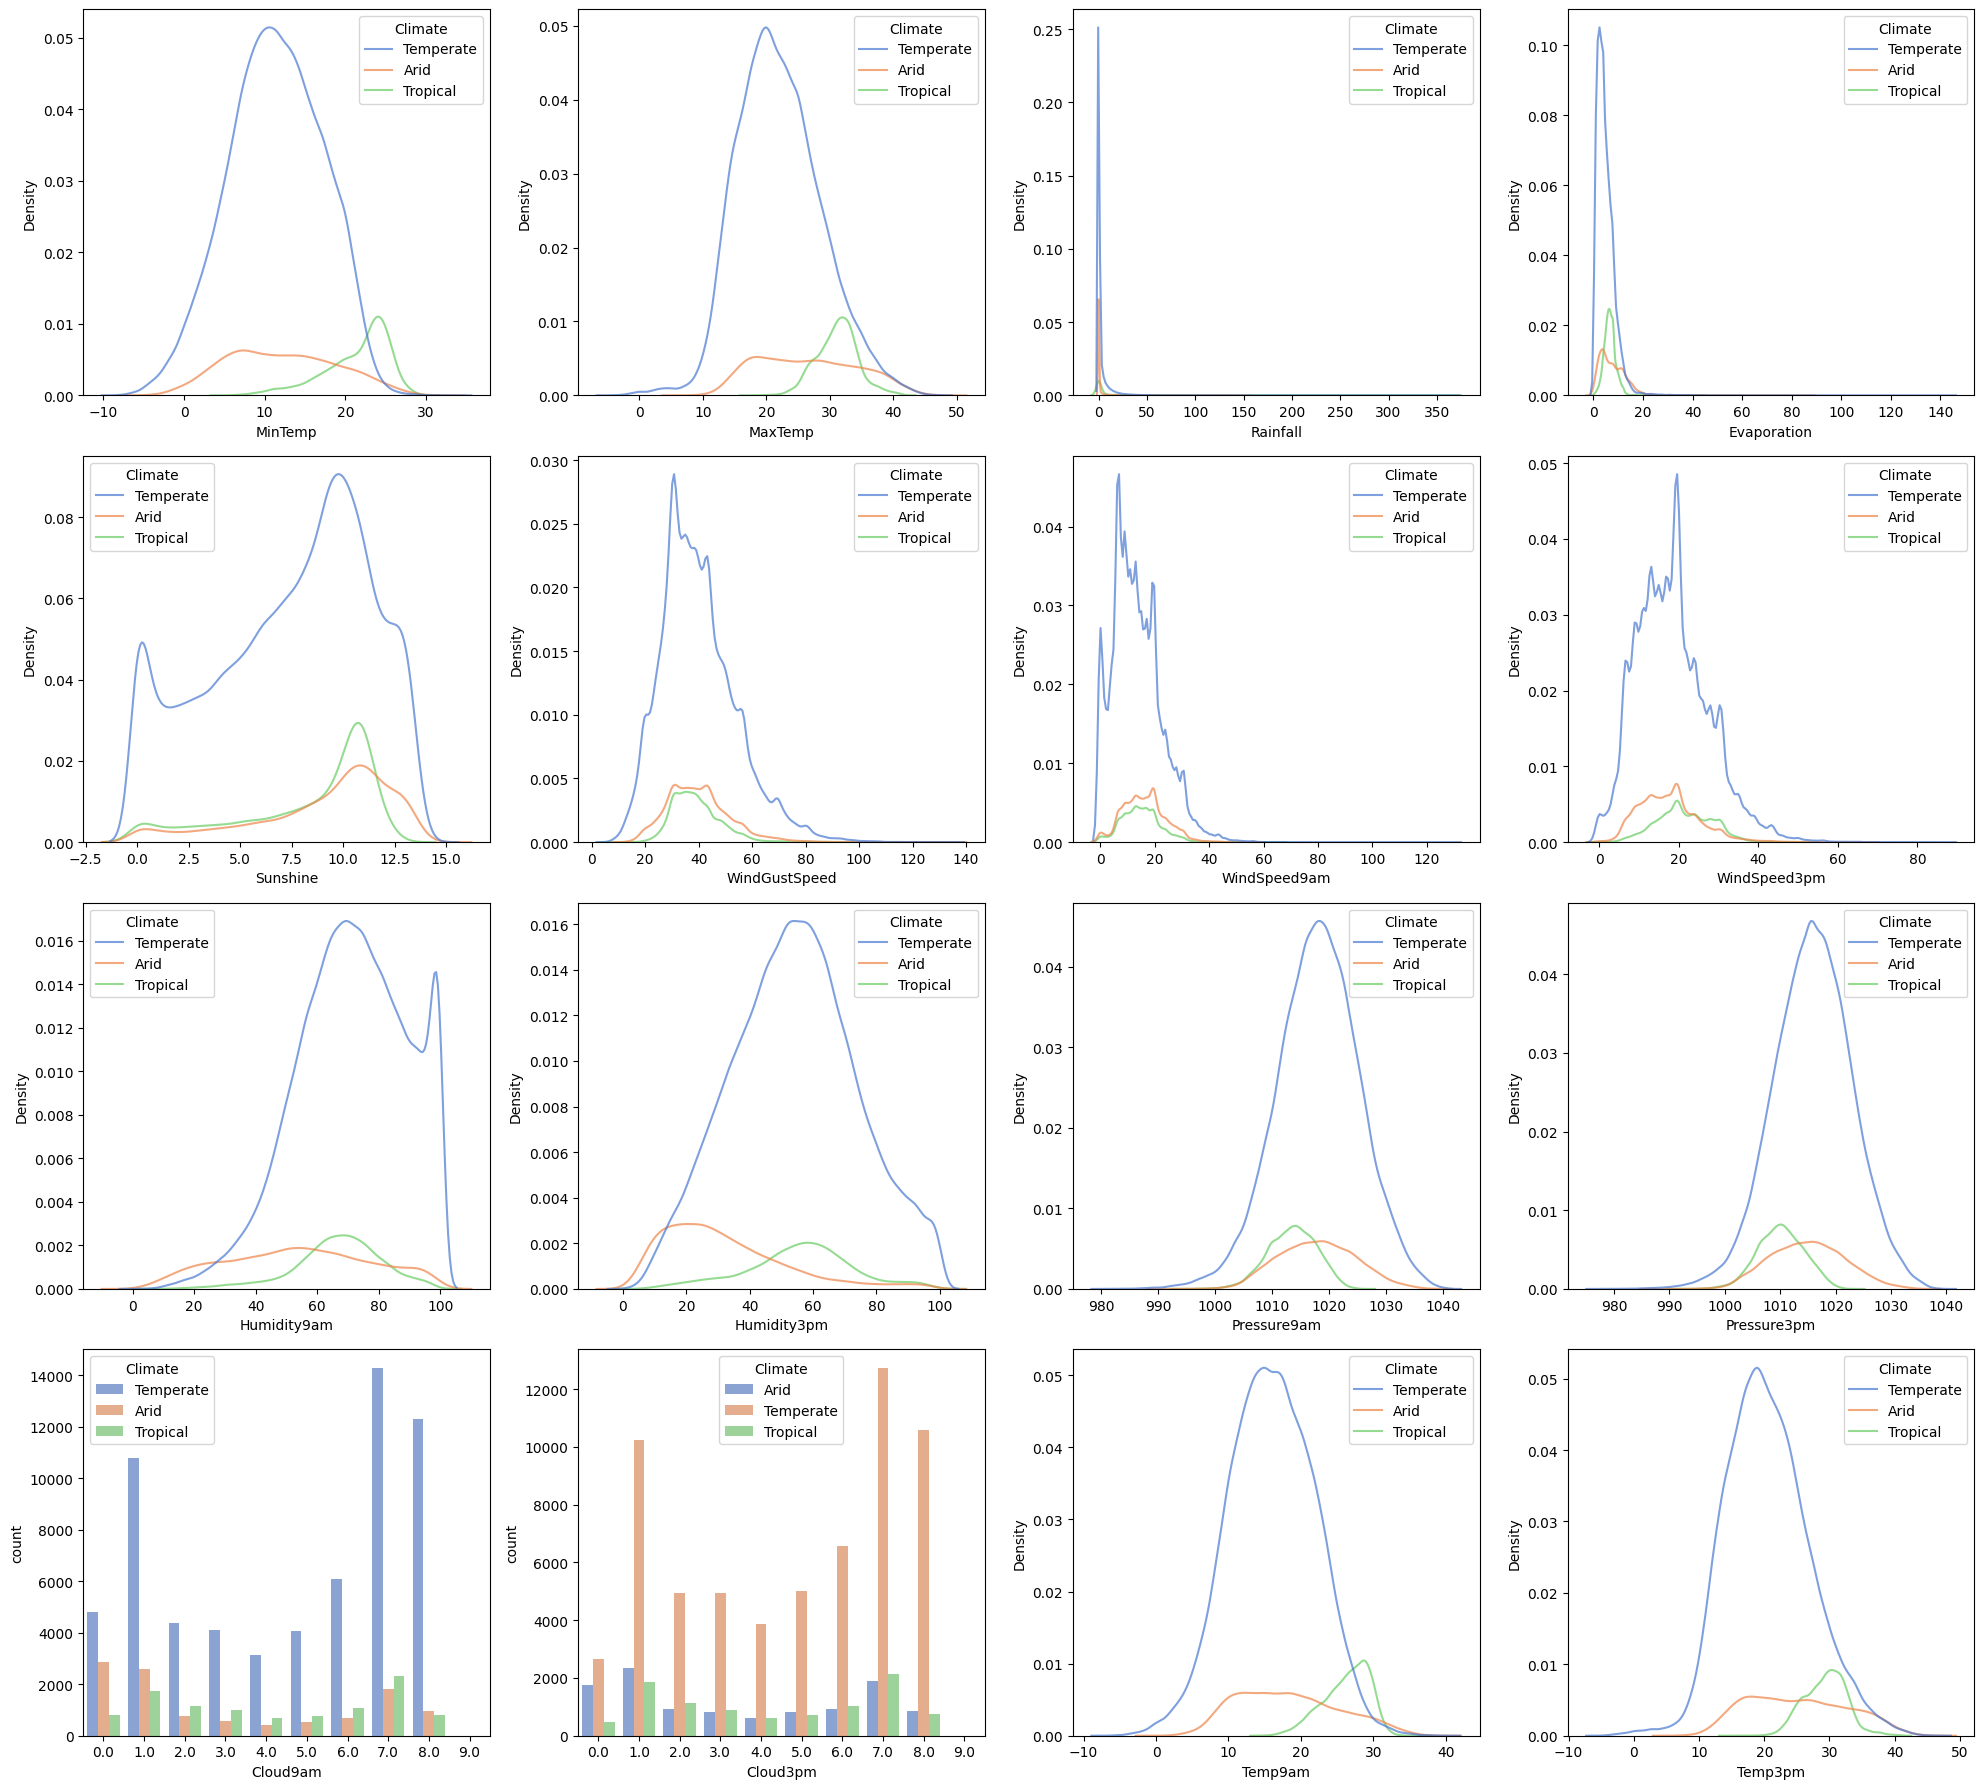

In [289]:
# Distribución de variables
fig, axes = plt.subplots(4, 4, figsize=(20, 18))

for i, var in enumerate(variables_numericas):
    if var == 'Cloud3pm' or var == 'Cloud9am':
        sns.countplot(data=df, x=var, hue='Climate', palette='muted', alpha=0.7, ax=axes[i // 4, i % 4])
    else:
        sns.kdeplot(data=df, x=var, hue='Climate', palette='muted', alpha=0.7, ax=axes[i // 4, i % 4])

plt.tight_layout()
plt.show()

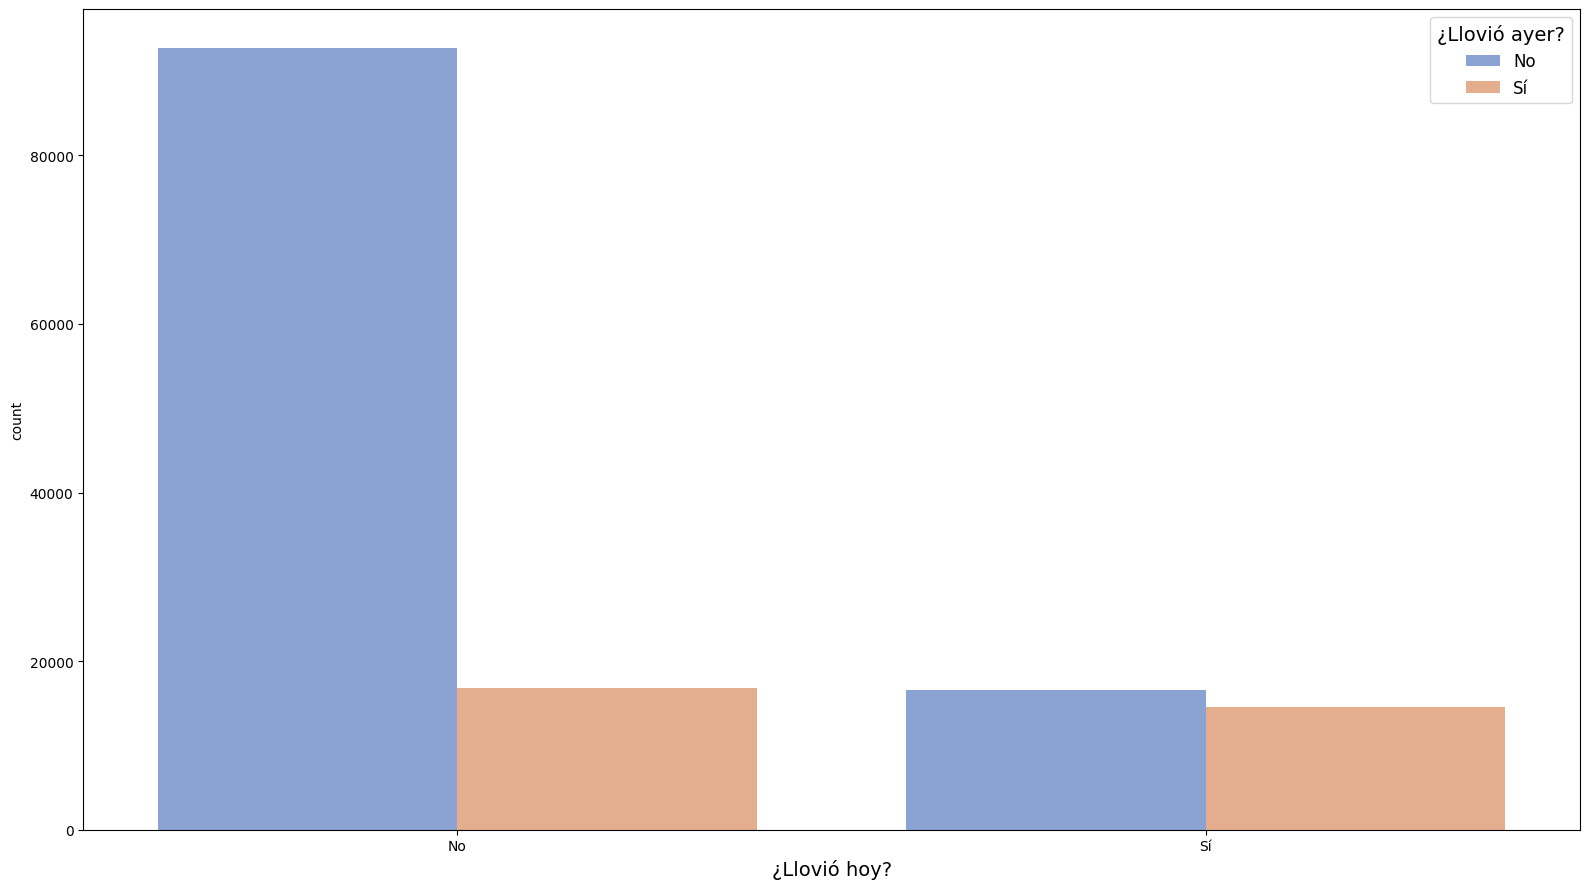

In [ ]:
fig = plt.figure(figsize=(16, 9))

sns.countplot(data=df, x='RainTomorrow', hue='RainToday', palette='muted', alpha=0.7)

plt.xlabel('¿Llovió hoy?', fontsize=14)
plt.xticks(ticks=[0, 1], labels=['No', 'Sí'])

plt.legend(title='¿Llovió ayer?', title_fontsize=14, labels=['No', 'Sí'], fontsize=12)

plt.tight_layout()
plt.show()

In [291]:
df['RainTomorrow'].value_counts()

RainTomorrow
0    110316
1     31877
Name: count, dtype: Int64

In [340]:
fig = plt.figure(figsize=(16, 9))

# Gráfico original
grafico = sns.countplot(data=df, x='RainTomorrow', hue='RainToday', palette='muted', alpha=0.7)

# Agrega las frecuencias absolutas y los porcentajes como anotaciones
for container in grafico.

plt.xlabel('¿Llovió hoy?', fontsize=14)
plt.ylabel('Frecuencia absoluta', fontsize=14)
plt.legend(title='¿Llovió ayer?', title_fontsize=14, labels=['No', 'Sí'], fontsize=12)
plt.xticks(ticks=[0, 1], labels=['No', 'Sí'])
plt.tight_layout()
plt.show()

SyntaxError: invalid syntax (4070162531.py, line 7)